We want to test the performance of a QIF framework for non-Markovian, covariance stationary process using non-linear quantised measurements.

#### TRUE DYNAMICS

We want to specify the true dynamics of QIF exactly such that only the measurement model is tested. To do this, we suggest that we will define the coefficients of an AR(q) process. We will use these coefficients to generate (a) a true sequence for f_n and (b) we are able to input the true coefficents into the dynamical model of QIF. Hence, true dynamics in QIF, in principle, can be exactly specified. 

However, this is  practically problematic:

- For low q, it is analytically possible to figure out what the AR coefficients should look like such that our truth is covariance stationary and non Markovian. We can use these analytic bounds to specify the coefficients such that f_n remains covariance stationary and non Markovian. However, low q regime is not comparable with regime that we have considered in the past, namely, that f_n was learned well if and only if q was large > 100

- For high q, no analytic solutions are available. We make an assumption than a LSF acting on covariance stationary, non Markovian f_n defines approximately the sorts of dynamics and power spectrum that we are looking for. We take these weights from LSF, and we define these to be "true" coefficients of an AR process that is comparable to f_n covariance stationary, non Markovian.

#### ASSESSMENT

We will assess QIF performance for tracking the likelihood z = 0.5 cos(f_n) in the low and high q regime

In [1]:
q_regime=[]

#### PREAMBLE COMMANDS ####

In [2]:
import sys
sys.path.append('../../../')


#### Local QIF Filter and Helper Functions ####
from qif.qif import qif as qif
from qif.common import generate_AR, noisy_z, projected_msmt, qkf_state_err, normalise
from ls.common import doLSF_forecast

#### Local Plotting Tools ####
from plot_tools.fig_preamble import *
from plot_tools.plot_figstyle_sheet import STYLEDICT, COLOURDICT
from plot_tools.plot_helper_funcs import cm2inch

#### Matplotlib & Numpy ####
import numpy as np
import matplotlib as mpl
mpl.rc('font', size=8)
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
import matplotlib.gridspec as gridspec


#### Global Plotting and Saving Commands ####

############ Saving Commands #########

ver=0
datapath = '../../DATA_v'+str(ver)+'_/' 
savefig = './analysis_figs'
figname = 'tc_19_v_1_LSF_likehood_z'

############ Plotting Commands ########
figx=8
figy=8

labels = [r'QKF(True $\Phi)$', r'QKF(AKF $\Phi$)', r'']
color = [COLOURDICT['QKF'], COLOURDICT['AKF'], COLOURDICT['TRUTH']]
figstyl = [STYLEDICT['QKF'], STYLEDICT['AKF'], '-']

/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1206: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:
/home/riddhisw/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1182: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markeredgecolor != ec:


#### LOW Q REGIME - AR(2) PROCESS

We need to satisfy the following constraints 

For stationarity:
    (a) ph1 + ph2 < 1
    (b) ph1 - ph2 < 1
    (c) phi2| < 1

In [3]:
######## Covariance Stationary, MS Ergoic AR(2) Process#######
# Stationary ARMA: http://matthieustigler.github.io/Lectures/Lect2ARMA.pdf

ar1 = -0.02# 
ar2 = +0.968
q_regime.append(np.asarray([ar1, ar2]))

#### HIGH Q REGIME - AR(q) PROCESS USING LEARNED LSF WEIGHTS

In [4]:
# We want to load a high order AR(q) model where we know that underlyign truth is stationary.

from data_tools.load_raw_cluster_data import LoadExperiment

experiment = LoadExperiment(19, 1, 
                            LKFFB_load ='No',
                            LSF_load='No',
                            AKF_load='Yes', 
                            AKF_path=datapath,
                            GPRP_load='No')

# We will now gradually move into the high q regime by considering the following weights:
q_regime.append(experiment.AKF_weights[0:7])
q_regime.append(experiment.AKF_weights[0:8])
q_regime.append(experiment.AKF_weights[0:9])
q_regime.append(experiment.AKF_weights[0:10])
q_regime.append(experiment.AKF_weights[0:15])
q_regime.append(experiment.AKF_weights[0:20])
q_regime.append(experiment.AKF_weights[0:30])
q_regime.append(experiment.AKF_weights[0:40])
q_regime.append(experiment.AKF_weights[0:60])
q_regime.append(experiment.AKF_weights[0:80])
q_regime.append(experiment.AKF_weights[0:])

AKF: Data Loaded? Yes


#### Noise Parameters

In order to generate our true process, we will keep the following process noise and measurement noise parameters the same, and we will feed the true values into QIF to side step auto-tuning of parameters

In [5]:
######## True Process Noise Strength
true_oe = 0.1**2
######## True Msmt Noise Strength
true_rk = 0.1**2
####

#### Set up of Algorithm Parameters (QKF, LSF)

In [6]:
###### Number of data points and initial points to exclude (burnin) #####
num = 2050
burn_in = 500

###### AR Process Initialisation #####
# we need phases to accumulate from 0 to pi. So our process is no longer mean zero.
mean_noise = 0.5*np.pi

###### Bayes Risk Runs ######
runs = 50

########### LSF ##############
pick_alpha=0.1
n_predict = 50
n_train=num-n_predict
num_of_iterGD = 50

########### KF ##############
p0init = 1000 # set same as AKF /LSF

#### Initial Condition , Truth and Data Set Generation with Scaling 

from scipy.signal import periodogram
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

plt.figure()
plt.plot(autocorr(noisy_z_), '-')
plt.plot(autocorr(true_x - mean_noise), ':')
plt.show()
plt.figure()
freq, amp = periodogram(noisy_z_)
plt.plot(freq, amp, ':')
plt.show()

plt.figure(figsize=(figx*2,figy*2))
plt.subplot(2,2,1)
plt.title('True State X (Detuning) with Initial Burnin Disgarded')
plt.plot(range(order), x_init + mean_noise, 'ro') 
plt.plot(true_x)
plt.axhline(y=np.pi, c='r')
plt.axhline(y=0, c='r')
plt.axvline(x=100, c = 'k')
#plt.ylim([-2*np.pi, 2*np.pi])

plt.subplot(2,2,2)
plt.title('Noisy State Z(x) (Probability)')
plt.plot(noisy_z_ + 0.5, '--' )
plt.plot(projected_msmt(noisy_z_ ), 'o')
#plt.ylim([-0.1, 1.1])

plt.subplot(2,2,3)
plt.title('Distribution of X - 1/2 pi')
plt.hist(true_x - mean_noise)

plt.subplot(2,2,4)
plt.title('Distribution of Z')
plt.hist(noisy_z_)
plt.show()

In [7]:
from scipy.signal import periodogram

def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size/2:]

####  Run 100 times; with QKF using true dynamics and LSF learned dynamics

('The true weights are of order: ', 2)


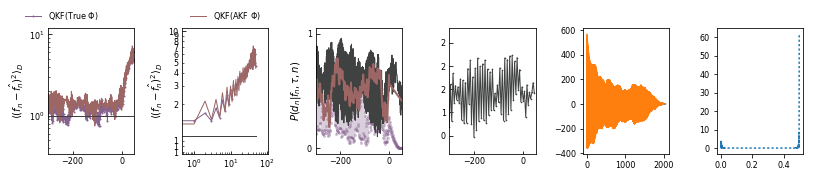

('The true weights are of order: ', 7)


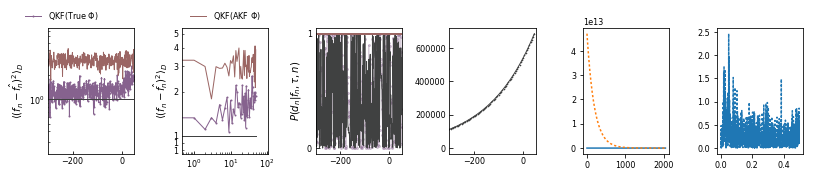

('The true weights are of order: ', 8)


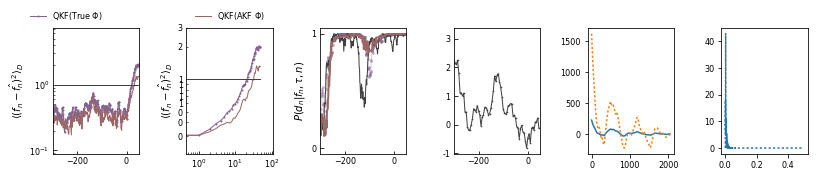

('The true weights are of order: ', 9)


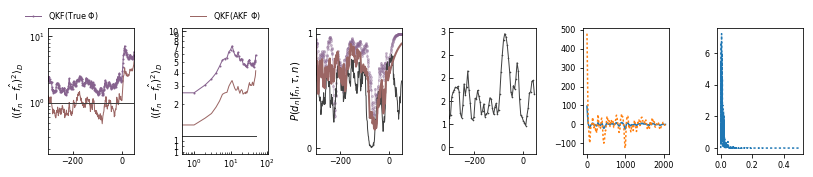

('The true weights are of order: ', 10)


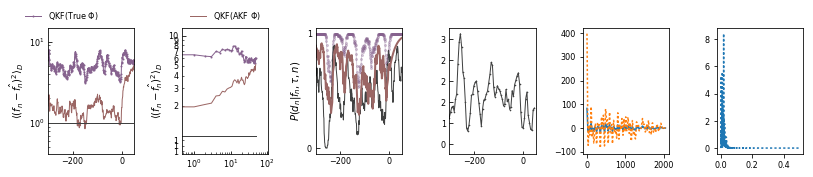

('The true weights are of order: ', 15)


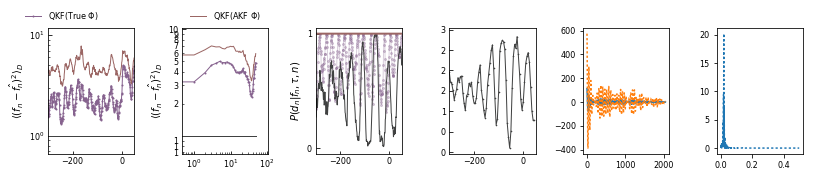

('The true weights are of order: ', 20)


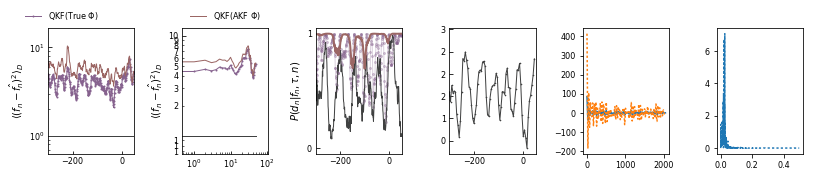

('The true weights are of order: ', 30)


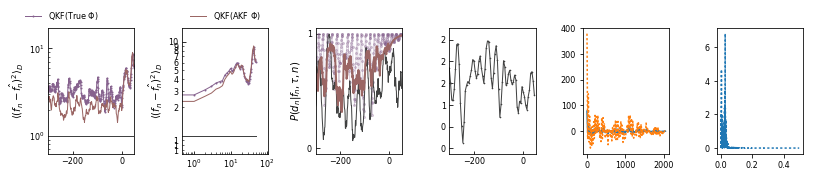

('The true weights are of order: ', 40)


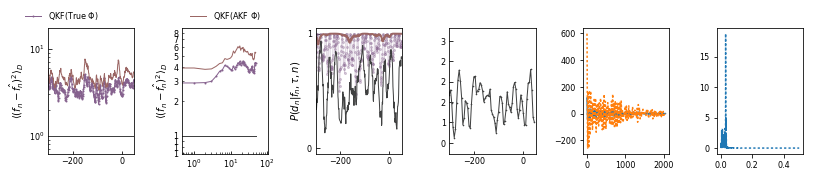

('The true weights are of order: ', 60)


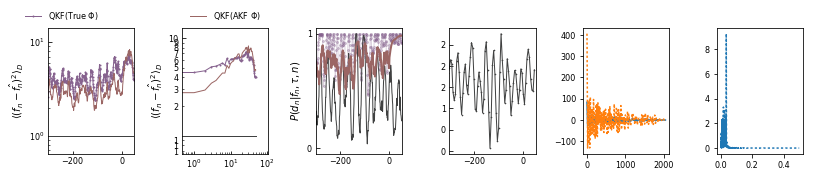

('The true weights are of order: ', 80)


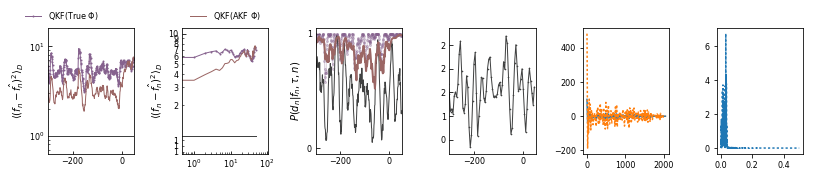

('The true weights are of order: ', 101)


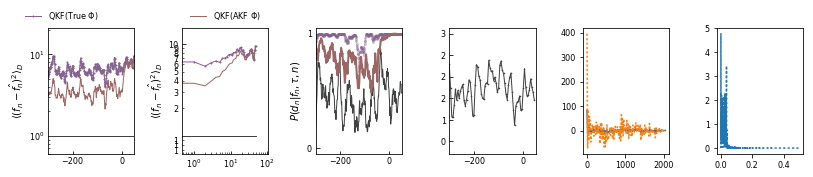

In [8]:
for idx_q_regime in xrange(len(q_regime)):
    
    

    # Pick the AR(q) regime of coefficients
    true_weights = q_regime[idx_q_regime]
    order = true_weights.shape[0]
    n_start_at=n_train - order + 1
    
    print("The true weights are of order: ", order)

    # Set random initial conditions. These apply to the entire experiment.
    x_init = np.random.uniform(low=-0.5*np.pi, high=0.5*np.pi, size=order)

    # We store the residuals and the x_hat 
    x_true_dynamics = np.zeros((runs, order, num))
    x_LSF_dynamics = np.zeros((runs, order, num))

    gain_true_dynamics = np.zeros((runs, order, num))
    gain_LSF_dynamics = np.zeros((runs, order, num))

    truths_ = np.zeros((runs, num))
    err_true_dynamics = np.zeros((runs, num))
    err_LSF_dynamics = np.zeros((runs, num))


    ######### Make an ensemble of QIF experiments ############

    for idx_run in xrange(runs):

        # Make truth for one run
        true_x = generate_AR(x_init, num + burn_in, true_weights, true_oe)[burn_in:] + mean_noise 
        truths_[idx_run, :] = true_x # this is mean 0.5 pi
        noisy_z_ = noisy_z(true_x, true_rk) # this is mean zero

        # Find LSF weights using quantised msmts
        measurements_train = noisy_z_#projected_msmt(noisy_z_)
        measurements_val = noisy_z_ #projected_msmt(noisy_z_) # true_x doesnt change
        object_ = doLSF_forecast(measurements_train, measurements_val, pick_alpha, 
                           n_start_at, n_predict, order, 
                           steps_between_msmts=1, num_of_iterGD=num_of_iterGD)

        # Generate validation dataset
        y_signal = projected_msmt(noisy_z_)

        # Run QIF using True Dynamics 
        predictions, W, x_hat, P_hat, err_true_dynamics[idx_run, :] = qif('truedynamics', y_signal, 
                                                                          true_weights, true_oe, true_rk, 
                                                                          n_train=n_train, 
                                                                          n_testbefore=n_predict, 
                                                                          n_predict=n_predict, 
                                                                          p0=p0init, skip_msmts=1,  save='No')
        # Run QIF using LSF Learned Dynamics 
        predictions_l, W_l, x_hat_l, P_hat_l, err_LSF_dynamics[idx_run, :] = qif('lsfdynamics', y_signal, 
                                                                                 object_[1][1].ravel() , 
                                                                                 true_oe, true_rk, 
                                                                                 n_train=n_train, 
                                                                                 n_testbefore=n_predict, 
                                                                                 n_predict=n_predict, 
                                                                                 p0=p0init, 
                                                                                 skip_msmts=1, save='No')
        # Store run for this experiment
        x_true_dynamics[idx_run, :, :] = x_hat[:,0,:]
        x_LSF_dynamics[idx_run, :, :] = x_hat_l[:,0,:]

        gain_true_dynamics[idx_run, :, :] = W[:,0,:]
        gain_LSF_dynamics[idx_run, :, :] = W_l[:,0,:]







    ######### Calculate Bayes Risk with respect to z for each experiment ############

    z_true_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_true_dynamics[:, 0, 0:num]])
    z_LSF_dynamics = np.asarray([noisy_z(sequence, 0.) for sequence in x_LSF_dynamics[:, 0, 0:num]])

    ######### Calculate Bayes Risk for predicting mean z = 0.5cos(f_n) == 0  ############
    truths_z = np.asarray([noisy_z(sequence, 0.) for sequence in truths_[:, 0:num]])
    predict_one = np.mean((truths_z)**2, axis=0)

    ######### Normalise Bayes Risk  ############

    norm_z_states_ = [(qkf_state_err(z_true_dynamics[:, :], truths_z)) / predict_one, 
                      (qkf_state_err(z_LSF_dynamics[:, :], truths_z)) / predict_one,
                      predict_one / predict_one]







    ######### Plot the Experiment   ############

    run = int(np.random.uniform(low=0, high = runs))

    gs = gridspec.GridSpec(1, 6,
                           left=0.21, right=0.95, 
                           top=0.9, bottom=0.16, 
                           wspace=0.55, hspace=0.2)


    fig = plt.figure(figsize=(cm2inch(36),cm2inch(6)))

    ax_2 = fig.add_subplot(gs[0, 0])# Bayes Risk wrt to z msmts [full]
    ax_0 = fig.add_subplot(gs[0, 1]) # Prediction Risk only
    ax_3 = fig.add_subplot(gs[0, 2]) # Single run likehood tracking
    ax_1 = fig.add_subplot(gs[0, 3])# fig.add_axes([0.72, 0.22, 0.11, 0.09]) # Single run detuninng
    ax_4 = fig.add_subplot(gs[0, 4])
    ax_5 = fig.add_subplot(gs[0, 5])
    
    # Autocorrelation and periodgram from one run
    
    ax_4.plot(autocorr(truths_z[run,:]), '-')
    ax_4.plot(autocorr(truths_[run,:] - mean_noise), ':')
    freq, amp = periodogram(truths_z[run,:])
    ax_5.plot(freq, amp, ':')
    
    # Single Run f_n

    ax_1.plot(np.arange(-n_train, n_predict, 5), truths_[run, ::5], 
                 'x-', label='Single Run Dephasing', c=COLOURDICT['TRUTH'], lw=1, ms=1.)
    ax_1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax_1.minorticks_off
    ax_1.set_xticks([-200, 0])


    # Bayes Risk wrt to z msmts
    for idx_algo in xrange(len(norm_z_states_)):   
        ax_0.plot(np.arange(0, n_predict, 1), norm_z_states_[idx_algo][n_train: num], 
                 figstyl[idx_algo], label=labels[idx_algo], c=color[idx_algo],
                  markeredgecolor=color[idx_algo], markerfacecolor=None, ms=1, alpha=1.0, lw=1)
    ax_0.margins(0.2)
    ax_0.set_yscale('log')
    ax_0.set_xscale('log')
    #ax_0.set_ylim([0.6,3.0])
    ax_0.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=1))
    ax_0.set_ylabel(r'$\langle (f_n -\hat{f_n})^2 \rangle_D$')
    ax_0.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    ax_0.yaxis.set_minor_formatter(FormatStrFormatter('%.0f'))

    # Bayes Risk wrt to z msmts
    for idx_algo in xrange(len(norm_z_states_)):   
        ax_2.plot(np.arange(-n_train, n_predict, 1), norm_z_states_[idx_algo][0: ], 
                 figstyl[idx_algo], label=labels[idx_algo], c=color[idx_algo],
                  markeredgecolor=color[idx_algo], markerfacecolor=None, ms=1, alpha=1.0, lw=1)
    ax_2.margins(0.2)
    ax_2.set_yscale('log')
    ax_2.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=3))
    ax_2.set_ylabel(r'$\langle (f_n -\hat{f_n})^2 \rangle_D$')
    ax_2.legend(loc=3,  fontsize=fsize, frameon=False, bbox_to_anchor=(-0.3, 1.02, 2.8, .102), 
                 ncol=3, mode="expand", borderaxespad=0.)


    # Single run likehood tracking
    ax_3.set_ylabel(r'$P(d_n | f_n, \tau, n)$')
    ax_3.plot(np.arange(-n_train, n_predict, 1),z_true_dynamics[run,:] + 0.5, 
             figstyl[0], label=labels[0], c=color[0], markeredgecolor=color[0], markerfacecolor=None,  alpha=0.3, 
              ms=2, lw=1)
    ax_3.plot(np.arange(-n_train, n_predict, 1),truths_z[run,:] + 0.5, 
             figstyl[2], label='Truth', c=color[2], markeredgecolor=color[2], markerfacecolor=None, alpha=1, ms=2, lw=1)
    ax_3.plot(np.arange(-n_train, n_predict, 1),z_LSF_dynamics[run,:] + 0.5, 
             figstyl[1], label=labels[1], c=color[1], markeredgecolor=color[1], markerfacecolor=None,  
              alpha=1, ms=1, lw=2)
    ax_3.set_yticks([0, 1])

    for ax in [ax_2, ax_0, ax_1, ax_3]: #ax_2
        ax.tick_params(direction='in', which='both')
        if ax != ax_0:
            ax.set_xlim([-300, 50])
        ax = set_font_sizes(ax, fsize, Fsize)

    fig.savefig(savefig+figname+'_q_'+idx_q_regime+'.svg', format='svg', dpi=400)
    plt.show()